In [246]:
import pandas as pd
import numpy as np
import wfdb
import ast
import time
from itertools import chain
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import acf
import os
import tqdm
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, auc, f1_score, roc_curve, RocCurveDisplay

### Загрузка данных

In [178]:
df = pd.read_csv('plt/ptbxl_database.csv')
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [179]:
# Чтение данных
path100 = 'plt/records100'
data = []
for filename in tqdm.tqdm(df['filename_lr']):
    data.append(wfdb.rdsamp(f'plt/{filename}'))

100%|██████████| 21799/21799 [05:37<00:00, 64.50it/s]


In [180]:
labels = df['scp_codes'].apply(ast.literal_eval)
labels

0                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
1                             {'NORM': 80.0, 'SBRAD': 0.0}
2                               {'NORM': 100.0, 'SR': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21794    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21795             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21796                           {'ISCAS': 50.0, 'SR': 0.0}
21797                           {'NORM': 100.0, 'SR': 0.0}
21798                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21799, dtype: object

In [181]:
agg_df = pd.read_csv('plt/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

series_labels = labels.apply(aggregate_diagnostic)
labels = []
for diagnosis in series_labels:
    if diagnosis == ['NORM']:
        labels.append(0)
    elif 'MI' in diagnosis:
        labels.append(1)
    else:
        labels.append(2)
labels = np.array(labels)

In [182]:
infos = [data[i][1] for i in range(len(data))]
data = np.array([data[i][0].T for i in range(len(data))])

### Свертка 6 отведений в 2 измерения

In [183]:
example = data[0]
main_lines = example[:6]
example.shape, main_lines.shape

((12, 1000), (6, 1000))

In [184]:
pca = PCA(n_components=2)
pca.fit(main_lines.T)
np.sum(pca.explained_variance_ratio_)

0.9999894565139176

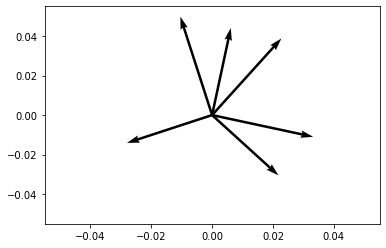

In [185]:
plt.quiver(*np.array([[0] * 6,[0] * 6]), pca.components_.T[:, 0], pca.components_.T[:, 1], scale=2)

### Сжатие других отведений

In [186]:
chest_leads = example[6:]
chest_leads.shape

(6, 1000)

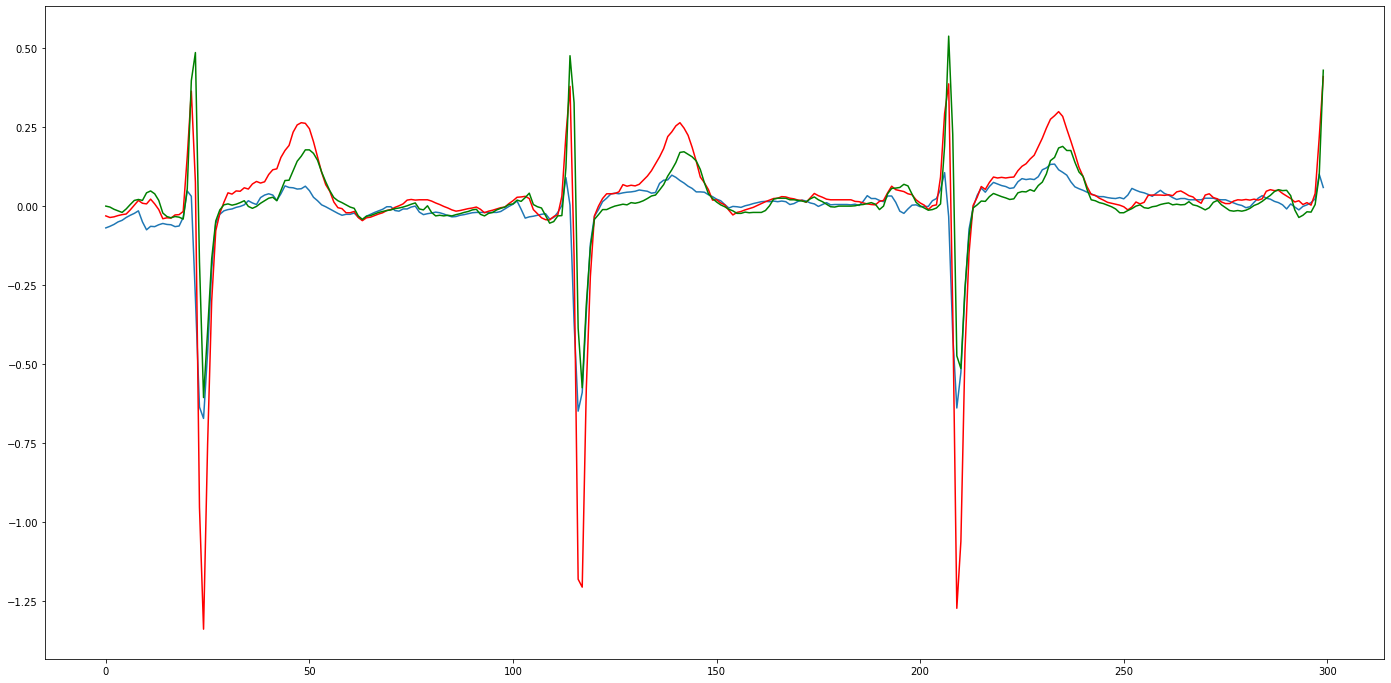

In [187]:
plt.figure(figsize=(24, 12))
plt.plot(chest_leads[0][:300])
plt.plot(chest_leads[1][:300], color='r')
plt.plot(chest_leads[2][:300], color='g')

In [188]:
for n_components in range(1, 6):
    chest_pca = PCA(n_components)
    chest_pca.fit(chest_leads.T)
    print(f'{n_components}-components PCA EVR: {np.sum(chest_pca.explained_variance_ratio_):.5f}')

1-components PCA EVR: 0.70241
2-components PCA EVR: 0.96361
3-components PCA EVR: 0.98904
4-components PCA EVR: 0.99553
5-components PCA EVR: 0.99841


In [189]:
def crosscorr(x, y, lag):
    return pd.Series(x).corr(pd.Series(y).shift(lag))

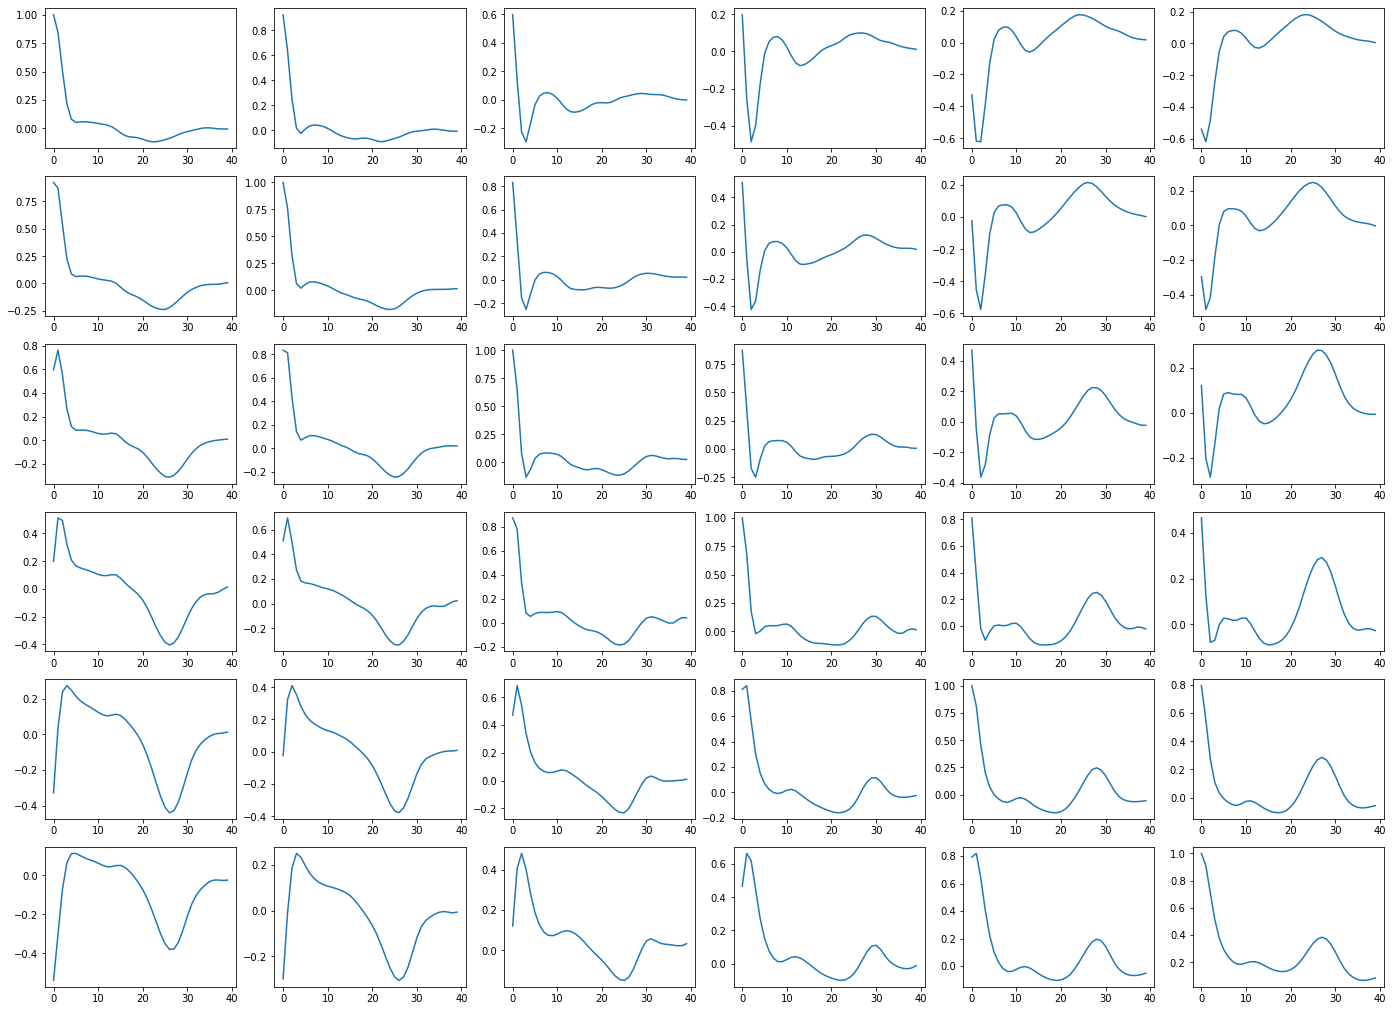

In [190]:
plt.figure(figsize=(24, 18))
for i in range(6):
    for j in range(6):
        ax = plt.subplot(6, 6, i * 6 + j + 1)
        corr = [crosscorr(chest_leads[i], chest_leads[j], lag) for lag in range(0, 40)]
        ax.plot(corr)

Как видно, грудные отведения линейно не зависимы а также уровень корелляции с лагом низок

### Удаление шумов

In [193]:
def moving_average(x, m):
    arr = pd.Series(x).rolling(m).mean().to_numpy()
    arr[0] = arr[1]
    return arr

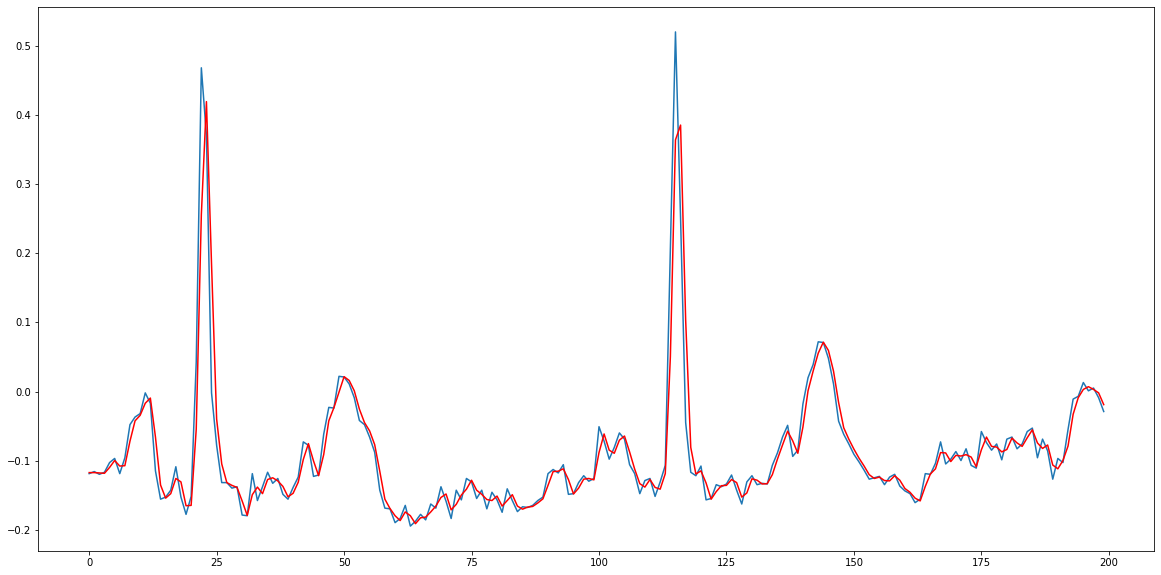

In [194]:
plt.figure(figsize=(20, 10))
plt.plot(data[0][0][:200])
plt.plot(moving_average(data[0][0][:200], 2), color='r')

Проверяем, везде ли одинаковые индексы соответствуют одинаковым отведениям

In [195]:
sig_names_forms = set()
for info in infos:
    sig_names_forms.add(tuple(info['sig_name']))
sig_names_forms

{('I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')}

Как видно, везде одинаковые индексы соответствуют одинаковым отведениям

Посмотрим какое среднее и разброс в разных отведениях

In [196]:
max_stds = []
min_stds = []
max_means = []
min_means = []
for i, sig_name in enumerate(infos[0]['sig_name']):
    max_stds.append(max([np.std(series[i]) for series in data]))
    min_stds.append(min([np.std(series[i]) for series in data]))
    max_means.append(max([np.mean(series[i]) for series in data]))
    min_means.append(min([np.mean(series[i]) for series in data]))
pd.DataFrame(
    [max_stds, min_stds, max_means, min_means], 
    index=['Max std', 'Min std', 'Max mean', 'Min mean'],
    columns=infos[0]['sig_name']
).transpose()

,Max std,Min std,Max mean,Min mean
I,1.119792,0.020332,0.860812,-5.556197
II,1.155264,0.029847,1.680857,-1.255718
III,1.265695,0.016976,5.561592,-1.643592
AVR,1.103834,0.032356,2.775160,-1.114005
AVL,1.068196,0.016626,1.252458,-5.558846
AVF,1.201932,0.020602,2.783237,-1.212937
V1,2.941952,0.021973,5.882733,-0.826611
V2,2.544925,0.038219,1.130133,-1.166814
V3,2.905499,0.039710,0.369889,-1.231775
V4,2.905028,0.029981,0.638397,-9.869941


Вывод графиков со средним и стандартным отклонением

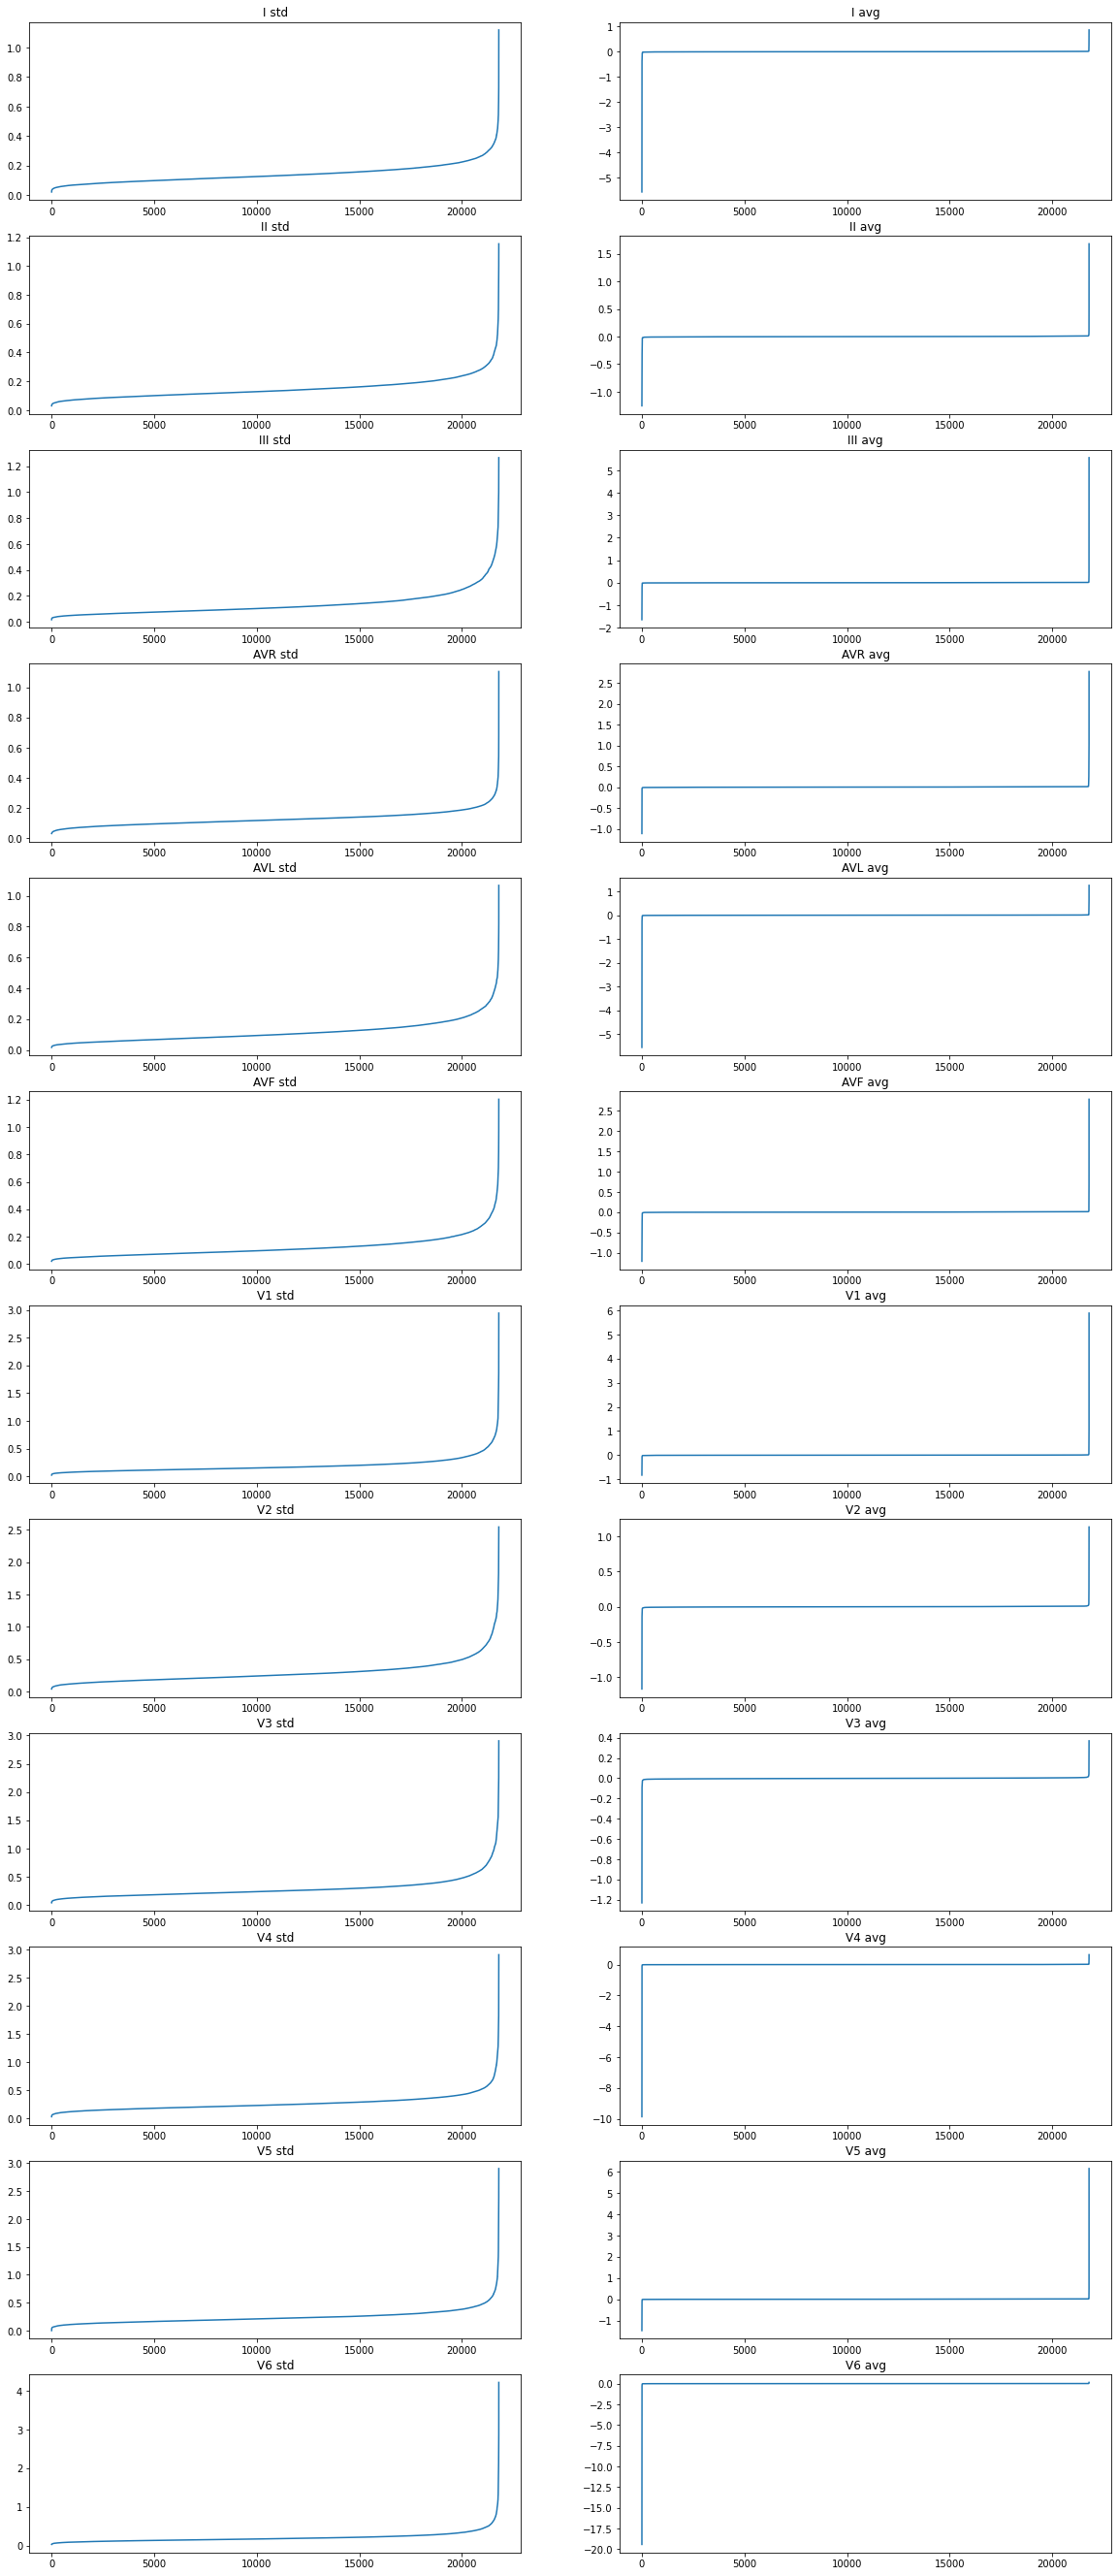

In [197]:
fig = plt.figure(figsize=(20, 48))
for i, sig_name in enumerate(infos[0]['sig_name']):
    ax = fig.add_subplot(12, 2, i * 2 + 1)
    ax.set_title(f'{sig_name} std')
    ax.plot(sorted([np.std(series[i]) for series in data]))
    ax = fig.add_subplot(12, 2, i * 2 + 2)
    ax.set_title(f'{sig_name} avg')
    ax.plot(sorted([np.mean(series[i]) for series in data]))

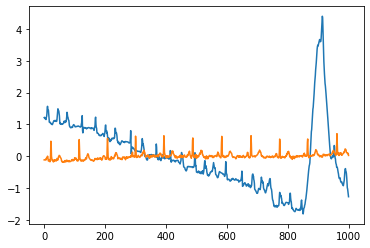

In [198]:
for series in data:
    if np.std(series[0]) > 0.8:
        plt.plot(series[0])
        break
for series in data:
    if np.std(series[0]) < 0.2:
        plt.plot(series[0])
        break

Вывод: необходимо удалять "Выбросы", примеры:

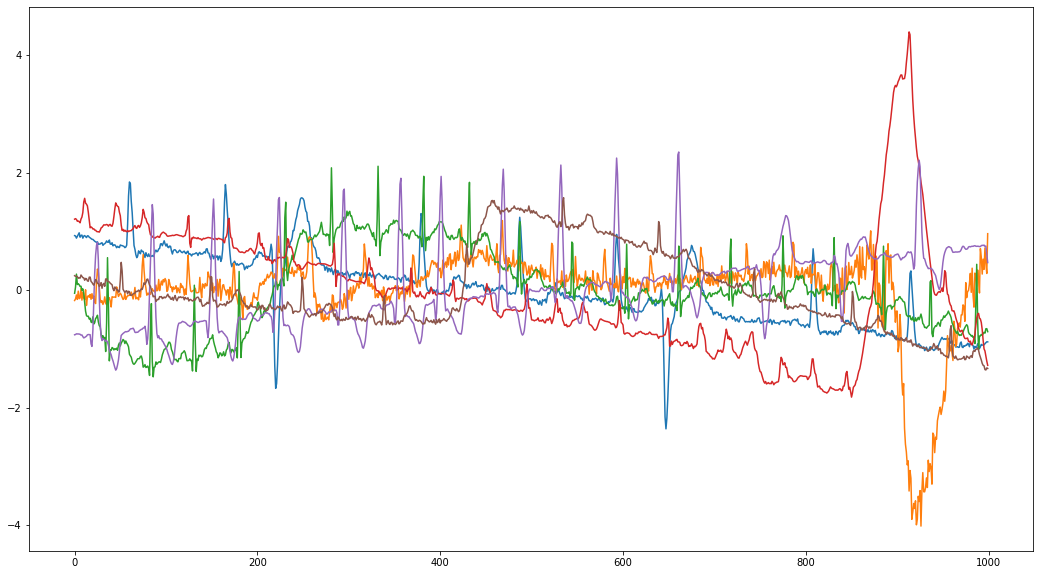

In [199]:
plt.figure(figsize=(18, 10))
cnt = 0
for series in data:
    if cnt > 5:
        break
    if 0.6 < np.std(series[0]):
        plt.plot(series[0])
        cnt += 1

Удаление выбросов

In [200]:
def is_acceptable(series, max_std, max_mean_range):
    for lead in series:
        if not (np.std(lead) < max_std and -max_mean_range < np.mean(lead) < max_mean_range):
            return False
    return True

In [201]:
print(f'Было объектов {len(data)}')

Было объектов 21799


In [202]:
labels = np.array([labels[i] for i in range(len(data)) if is_acceptable(data[i], 0.65, 0.05)])
filtred_data = [series for series in data if is_acceptable(series, 0.65, 0.05)]
print(f'Стало объектов {len(labels)}')

Стало объектов 20026


Отбрасывание остальных диагнозов

In [203]:
filtred_data = np.array(filtred_data)[labels != 2]

In [204]:
labels = labels[labels != 2]

In [205]:
print(f'Стало объектов {len(filtred_data)}')

Стало объектов 13792


Применение moving_average

In [206]:
def moving_average_quality(processed, original):
    return np.abs(processed - original)

def apply_moving_average(example, window):
    ma_processed = np.copy(example)
    for i in range(len(ma_processed)):
        ma_processed[i] = moving_average(ma_processed[i], window)
    return ma_processed

In [207]:
ma_data = np.array([apply_moving_average(ex, 2) for ex in filtred_data])

### Обучение модели

Балансировка данных

In [208]:
values, counts = np.unique(labels, return_counts=True)
print(values, counts)

[0 1] [8769 5023]


In [209]:
indexes_for_zeros = np.array(range(len(labels)))[labels == 0]
indexes_for_ones = np.array(range(len(labels)))[labels == 1]
indexes_for_zeros_sample = np.random.choice(indexes_for_zeros, counts[1], replace=False)
balanced_labels = np.concatenate([labels[indexes_for_ones], labels[indexes_for_zeros_sample]], axis=0)
balanced_data = np.concatenate([ma_data[indexes_for_ones], ma_data[indexes_for_zeros_sample]], axis=0)

Разделение на тестовую и тренировочную выборки

In [210]:
x_train, x_test, y_train, y_test = train_test_split(balanced_data, balanced_labels, test_size=0.3, random_state=0)

Архитектура сети

In [224]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #self.seq = nn.Sequential(
        #    nn.Conv1d(in_channels=12, out_channels=48, kernel_size=7, stride=2),
        #    nn.ReLU(),
        #    nn.MaxPool1d(2, 2),
        #
        #    nn.Conv1d(in_channels=48, out_channels=144, kernel_size=5, stride=2),
        #    nn.ReLU(),
        #    nn.MaxPool1d(2, 2),
        #
        #    nn.Conv1d(in_channels=144, out_channels=288, kernel_size=5, stride=2),
        #    nn.ReLU(),
        #    nn.MaxPool1d(2, 2),
        #
        #    nn.Flatten(),
        #
        #    nn.Linear(in_features=4320, out_features=500),
        #    nn.ReLU(),
        #    nn.Linear(in_features=500, out_features=1)
        #)
        self.conv1 = nn.Conv1d(
            in_channels=12, 
            out_channels=48,
            kernel_size=7,
            stride=2
        )
        self.conv2 = nn.Conv1d(
            in_channels=48,
            out_channels=144,
            kernel_size=5,
            stride=2,
        )
        self.conv3 = nn.Conv1d(
            in_channels=144,
            out_channels=288,
            kernel_size=5,
            stride=2
        )
        self.fc1 = nn.Linear(in_features=4032, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x
        #return self.seq(x)


Обучение сети

In [263]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net = Model().to(device)
print(net)

cpu
Model(
  (conv1): Conv1d(12, 48, kernel_size=(7,), stride=(2,))
  (conv2): Conv1d(48, 144, kernel_size=(5,), stride=(2,))
  (conv3): Conv1d(144, 288, kernel_size=(5,), stride=(2,))
  (fc1): Linear(in_features=4032, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1, bias=True)
)


In [264]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

def test(net, samples):
    with torch.no_grad():
        return net.forward(torch.Tensor(samples))

def train(net, samples, labels, epochs, batch_size):
    samples = torch.Tensor(samples)
    labels = torch.Tensor(np.array([labels]).T)
    dataset = TensorDataset(samples, labels)
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    start_time = time.time()

    for epoch in range(epochs):
        loss_value = 0.0
        for i, batch in enumerate(dataloader):
            inputs, labels = batch[0].to(device, non_blocking=True), batch[1].to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_value += loss.item()
        print(f'Epoch {epoch:5} loss = {loss_value:.4f}')
        print(f'\tTrain accuracy: {accuracy_score(y_train, [(1 if pred[0] > 0.5 else 0) for pred in test(net, x_train)])}')
        print(f'\tTest accuracy: {accuracy_score(y_test, [(1 if pred[0] > 0.5 else 0) for pred in test(net, x_test)])}')

In [265]:
train(net, x_train, y_train, 20, 128)

Epoch     0 loss = 34.2991
	Train accuracy: 0.7696245733788396
	Test accuracy: 0.7624419376244194
Epoch     1 loss = 22.8938
	Train accuracy: 0.8457053469852105
	Test accuracy: 0.8463835434638355
Epoch     2 loss = 18.9295
	Train accuracy: 0.8623435722411832
	Test accuracy: 0.8676177836761778
Epoch     3 loss = 17.1928
	Train accuracy: 0.8808304891922639
	Test accuracy: 0.8752488387524884
Epoch     4 loss = 16.5867
	Train accuracy: 0.8869453924914675
	Test accuracy: 0.8785666887856669
Epoch     5 loss = 15.4711
	Train accuracy: 0.8917804323094426
	Test accuracy: 0.882879893828799
Epoch     6 loss = 14.9307
	Train accuracy: 0.8936291240045506
	Test accuracy: 0.8865295288652952
Epoch     7 loss = 14.4800
	Train accuracy: 0.8934869169510807
	Test accuracy: 0.8838752488387525
Epoch     8 loss = 14.4496
	Train accuracy: 0.8977531285551763
	Test accuracy: 0.8861977438619775
Epoch     9 loss = 14.4720
	Train accuracy: 0.8991751990898749
	Test accuracy: 0.8885202388852024
Epoch    10 loss = 13

Accuracy

In [266]:
print(f'Train accuracy: {accuracy_score(y_train, [(1 if pred[0] > 0.5 else 0) for pred in test(net, x_train)])}')
print(f'Test accuracy: {accuracy_score(y_test, [(1 if pred[0] > 0.5 else 0) for pred in test(net, x_test)])}')

Train accuracy: 0.9183731513083049
Test accuracy: 0.8934970139349702


ROC-AUC

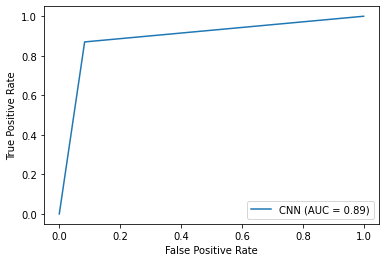

In [267]:
fpr, tpr, thresholds = roc_curve(y_test, [(1 if pred[0] > 0.5 else 0) for pred in test(net, x_test)])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='CNN')
display.plot()
plt.show()